# Import Modules

In [ ]:
import torch

import torch.nn as nn

from torch.autograd import Variable
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
import random

from collections import Counter
from tqdm import tqdm

# Set seed for reproducability

In [ ]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Connect to Google Drive

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# create a symbolic link
!ln -s /content/gdrive/My\ Drive/ /mydrive

!ls /mydrive

# navigate to /mydrive/car-damage-project
%cd /mydrive/car-damage-project

/
Mounted at /content/gdrive
 Adriana.jpg	     'FDS - Team 4.gsheet'   output.txt		   VAMR.gdoc
 car-damage-project  'IACV Cards.gdoc'	     pytorch-tutorial	   yolov4
'Colab Notebooks'    'Introduction to ML'   'USA 2019'
 drive_data	      output_resnet.txt     'VAMR Complete.gdoc'
/content/gdrive/My Drive/car-damage-project


# Load Images & Check their properties

First we are going to build a customized Car Dataset class in order to load the images. Since the images have different sizes, we are first going to reshape all of them to one common size (224, 224, 3). Then, we are going to calculate the mean and the standard deviation from the dataset in order to normalize the images.

In [ ]:
# create custom Dataset class
class carDataset(Dataset):
    def __init__(self, path_file, transform = None):
        # Define the instance variables
        self.transform = transform
        with open(path_file, 'r') as f:
            self.paths = f.readlines()
            
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        label, img_path = self.paths[idx].strip().split(',')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
            
        return img, int(label)

In [ ]:
# generate training and test paths
#!python gen_paths.py

In [ ]:
# display original images
train_orig = carDataset('trainpaths.txt')
test_orig = carDataset('testpaths.txt')

img_damaged_train = []
img_whole_train = []
img_damaged_test = []
img_whole_test = []

for i in range(len(train_orig)):
    img, label = train_orig[i]
    if label == 0:
        img_damaged_train.append(img.shape)
    elif label == 1:
        img_whole_train.append(img.shape)

for i in range(len(test_orig)):
   img, label = test_orig[i]
   if label == 0:
     img_damaged_test.append(img.shape)
   elif label == 1:
     img_whole_test.append(img.shape)

There are 132 unique damaged car train images.
There are 385 unique whole car train images.


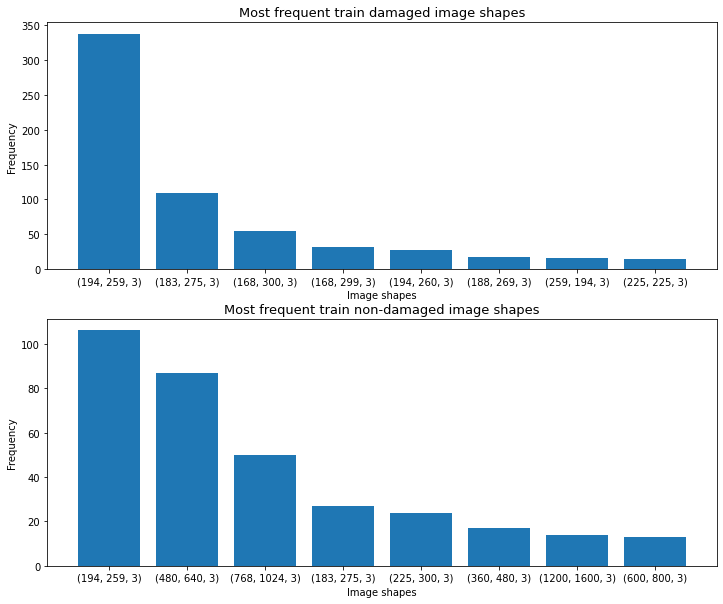

In [ ]:
img_damaged_train_ct = Counter(img_damaged_train).most_common(8)
img_whole_train_ct = Counter(img_whole_train).most_common(8)
shapes_d_train = [str(a_tuple[0]) for a_tuple in img_damaged_train_ct]
frequency_d_train = [a_tuple[1] for a_tuple in img_damaged_train_ct]
shapes_w_train = [str(a_tuple[0]) for a_tuple in img_whole_train_ct]
frequency_w_train = [a_tuple[1] for a_tuple in img_whole_train_ct]

print('There are {} unique damaged car train images.'.format(len(Counter(img_damaged_train).values())))
print('There are {} unique whole car train images.'.format(len(Counter(img_whole_train).values())))

plt.figure(1, figsize=(12,10))
plt.subplot(2, 1, 1)
plt.bar(shapes_d_train, height = frequency_d_train)
plt.xlabel('Image shapes')
plt.ylabel('Frequency')
plt.title("Most frequent train damaged image shapes", fontsize=13)

plt.subplot(2, 1, 2)
plt.bar(shapes_w_train, height = frequency_w_train)
plt.xlabel('Image shapes')
plt.ylabel('Frequency')
plt.title("Most frequent train non-damaged image shapes", fontsize=13)
plt.show()

There are 59 unique damaged car test images.
There are 130 unique whole car test images.


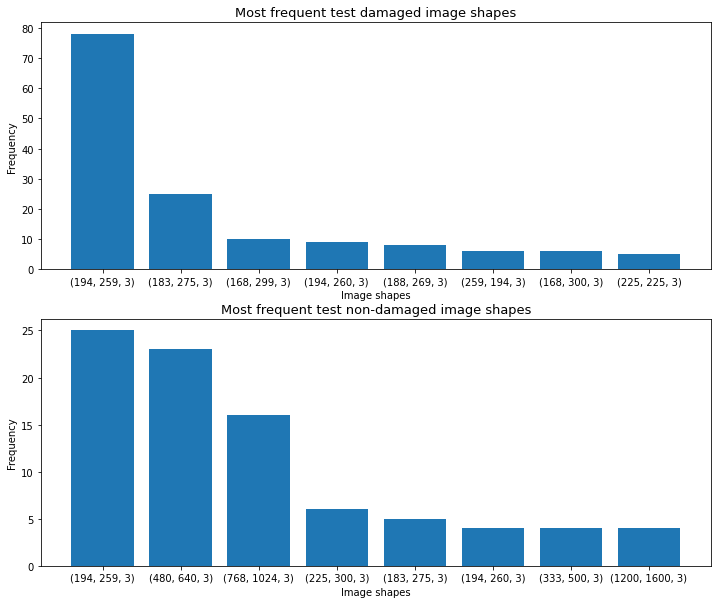

In [ ]:
img_damaged_test_ct = Counter(img_damaged_test).most_common(8)
img_whole_test_ct = Counter(img_whole_test).most_common(8)
shapes_d_test = [str(a_tuple[0]) for a_tuple in img_damaged_test_ct]
frequency_d_test = [a_tuple[1] for a_tuple in img_damaged_test_ct]
shapes_w_test = [str(a_tuple[0]) for a_tuple in img_whole_test_ct]
frequency_w_test = [a_tuple[1] for a_tuple in img_whole_test_ct]

print('There are {} unique damaged car test images.'.format(len(Counter(img_damaged_test).values())))
print('There are {} unique whole car test images.'.format(len(Counter(img_whole_test).values())))

plt.figure(1, figsize=(12,10))
plt.subplot(2, 1, 1)
plt.bar(shapes_d_test, height = frequency_d_test)
plt.xlabel('Image shapes')
plt.ylabel('Frequency')
plt.title("Most frequent test damaged image shapes", fontsize=13)

plt.subplot(2, 1, 2)
plt.bar(shapes_w_test, height = frequency_w_test)
plt.xlabel('Image shapes')
plt.ylabel('Frequency')
plt.title("Most frequent test non-damaged image shapes", fontsize=13)
plt.show()

In [ ]:
# define resizing to (224, 224, 3) and load dataset again
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
    ]),
}

data_dir = '../car-damage-project/kaggle_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training', 'validation']}

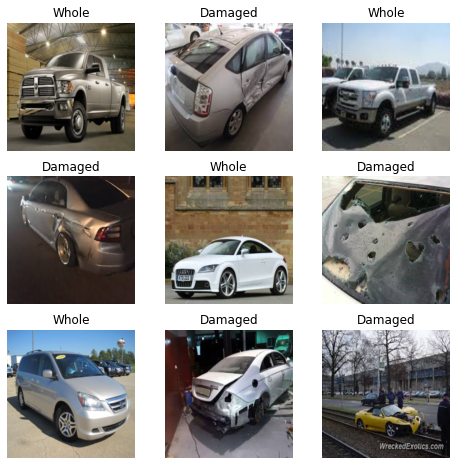

In [ ]:
# visualize the resized images
# visualize some of the loaded data with the transformations applied
labels_map = {
    0: "Damaged",
    1: "Whole"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_datasets['training']), size=(1,)).item()
    img, label = image_datasets['training'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0))
plt.show()

Since this size looks good for further processing, we will now calculate the mean and standard deviation for the dataset. This needs to be done so that we can normalize the images for the networks.

In [ ]:
train_loader = DataLoader(dataset=image_datasets['training'], batch_size=1840, shuffle=True)
test_loader = DataLoader(dataset=image_datasets['validation'], batch_size=460, shuffle=False)

def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, label in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean_train, std_train = get_mean_std(train_loader)
mean_test, std_test = get_mean_std(test_loader)

In [ ]:
print(mean_train, std_train)
print(mean_test, std_test)

tensor([0.4602, 0.4498, 0.4482]) tensor([0.2790, 0.2775, 0.2830])
tensor([0.4658, 0.4550, 0.4553]) tensor([0.2843, 0.2827, 0.2878])
